<a href="https://colab.research.google.com/github/AAnuvrath/wicked_wench/blob/main/notebooks/01b-exercise-decision-trees-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Regression using Decision Trees

In this notebook, we will use decision trees to solve regression problems.

The dataset used here originates from a project to build a surrogate model for predicting the band gap of a material from its composition. This surrogate model was used to replace expensive qunatum mecahnical calculations in virtual high-throughput screening of materials for application as photocatalysts. The paper was published in [Chemistry of Materials](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b01519).

Through this practice, we can learn not only the usage of regression trees but, more importantly, how to tune hyperparameters for best performance.

In [2]:
# import the data
!wget https://zenodo.org/record/4450207/files/training_data.pickle
oxides = pd.read_pickle('./training_data.pickle')

--2025-02-15 11:39:40--  https://zenodo.org/record/4450207/files/training_data.pickle
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4450207/files/training_data.pickle [following]
--2025-02-15 11:39:40--  https://zenodo.org/records/4450207/files/training_data.pickle
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 900335 (879K) [application/octet-stream]
Saving to: ‘training_data.pickle’

training_data.pickl 100%[===================>] 879.23K  4.64MB/s    in 0.2s    

2025-02-15 11:39:40 (4.64 MB/s) - ‘training_data.pickle’ saved [900335/900335]



---

# The Dataset

Our data are stored in the pickle file `./training_data.pickle`. We load this file into a `pandas.DataFrame` object, an efficient interface to manage column-wise, heterogeneous tabular data.

We can check all the columns presented in the dataframe:

In [3]:
# list all the features (columns) of the dataframe
list(oxides.columns)

['gllbsc_gap',
 '0-norm',
 '2-norm',
 '3-norm',
 '5-norm',
 '7-norm',
 '10-norm',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieData mode MeltingT',
 'MagpieData minimum Column',
 'MagpieData maximum Column',
 'MagpieData range Column',
 'MagpieData mean Column',
 'MagpieData 

In [4]:
# display the dataframe
oxides

,gllbsc_gap,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,band center,HOMO_energy,LUMO_energy,gap_AO
14,3.178134,3,0.661828,0.595447,0.559131,0.549905,0.546393,8.0,46.0,38.0,...,2.181818,0.909091,0.000000,True,0.774266,0.179393,-2.107646,-0.160771,-0.160771,0.000000
16,6.064334,3,0.755148,0.731509,0.727419,0.727279,0.727273,8.0,75.0,67.0,...,2.909091,1.818182,2.545455,False,0.551131,0.095839,-2.888538,-0.338381,-0.258639,0.079742
22,5.143263,2,0.769309,0.729210,0.715743,0.714453,0.714293,8.0,73.0,65.0,...,2.857143,0.857143,4.000000,True,0.609724,0.124433,-2.713737,-0.338381,-0.182464,0.155917
23,3.833288,4,0.623241,0.568848,0.548849,0.546062,0.545508,8.0,78.0,70.0,...,2.181818,1.727273,1.272727,True,0.787757,0.170601,-2.187003,-0.273634,-0.273634,0.000000
28,3.881077,3,0.612372,0.538609,0.506099,0.501109,0.500098,8.0,51.0,43.0,...,2.750000,2.500000,0.000000,True,0.820234,0.170098,-2.111889,-0.338381,-0.185623,0.152758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,7.162802,3,0.674997,0.629099,0.616414,0.615482,0.615388,8.0,56.0,48.0,...,2.923077,1.538462,0.000000,True,0.803211,0.157164,-2.347366,-0.338381,-0.338381,0.000000
2364,6.588943,4,0.661438,0.629961,0.625120,0.625003,0.625000,5.0,56.0,51.0,...,3.000000,1.250000,0.000000,True,0.803211,0.128401,-2.570595,-0.338381,-0.338381,0.000000
2368,3.423648,4,0.559017,0.478233,0.431116,0.414061,0.401916,5.0,56.0,51.0,...,2.000000,1.250000,0.000000,True,0.803211,0.175692,-1.833334,-0.197497,-0.197497,0.000000
2377,8.772669,4,0.634648,0.592816,0.583784,0.583359,0.583334,5.0,56.0,51.0,...,2.666667,0.000000,0.000000,True,0.803211,0.138693,-2.482281,-0.338381,-0.338381,0.000000


To read data from one of the columns, use the `values` attribute, for example:

### Description of the dataset

In this practical we are attempting to learn a model that can predict the band gap (energy separation between occupied and un-occupied orbitals) of a material. So we need to set this value as the property to be predicted $y$ This data is stored in the dataframe column called `gllbsc_gap` and we set this to be y by running the cell below:

In [5]:
# assign the data in 'gllbsc_gap' as the target variable 'y'
y = oxides['gllbsc_gap'].values
print(y.shape)

(749,)


We can then use the other properties in the dataset, or a combination of them as *features* ($X$) for our model. For example we could set X to be defined by two features by running the cell below:

In [6]:
# read multiple columns and combine them to a matrix
X = oxides[['MagpieData minimum Number', 'MagpieData maximum Number']].values
print(X.shape)

(749, 2)


## Regression with the dataset

In regression, we attempt to fit a model, $y = f(x)$, where $x$ and $y$ are multi-dimensional data of rank $M$ and $N$, respectively, and $f: \mathbb{R}^M\rightarrow\mathbb{R}^N$ our regression model. In this notebook, $y$ will always be `gllbsc_gap` (so $N=1$), which represents the band gap, and $x$ a combination of the descriptors (all the other columns), each giving the measurement of a certain physical property.

---

# Linear regression: a starter

Linear regression is the simplest regression algorithm in machine learning. Many people do not even regard it as a machine learning algorithm because it is explicitly programmed. Still, it serves as a good start to learn some basic concepts.


## Univariate regression

In univariate linear regression we have the equation:
$y = mx + c$
and we are attempting to find the best values for $m$ and $c$

In a univariate regression, the input rank $M=1$. For instance, let us try `MagpieData avg_dev Electronegativity` as $x$:

In [7]:
# perpare the input variable X
X = oxides['MagpieData avg_dev Electronegativity'].values

# we need to append a dummy dimension to X for univariate regression
# to keep the input dimensions consistent with multivariate regression
X = X.reshape(-1, 1)

# read y
y = oxides['gllbsc_gap'].values

Now we can use linear regression to fit the data and make predictions:

In [8]:
# fit linear regression model
model = LinearRegression().fit(X, y)
# make predictions
y_pred = model.predict(X)

When we have fitted the model we now want to use some *metrics* to *evaluate* the model performance. Remember the mean squared error and mean absolute error from your lectures. We will now calculate them for the model:

In [9]:
# compute some fitting error
print('MSE = %f eV' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f eV' % metrics.mean_absolute_error(y, y_pred))

MSE = 5.157564 eV
MAE = 1.833979 eV


We can also plot the predicted versus the real values to get a visual feel for how well the fitting worked.

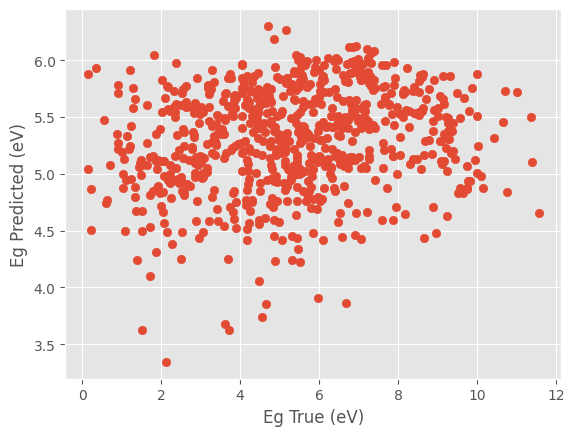

In [10]:
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

## Exercise

By changeing the feature in the $X$ values above try a number of different features. How does it affect the quality of fitting? Report the feature and the MAE and MSE scores in the table below. *Note* to edit the contets of this cell, simply double click on the cell.

| Feature | MAE (eV) | MSE (eV) |
|---------|----------|----------|
|         |          |          |
|         |          |          |
|         |          |          |
|         |          |          |

## Multivariate regression

In a multivariate regression, the input rank $M>1$. Therefore, we will choose a few descriptor to form $x$. Here we choose three descriptors ($M=3$):

In [11]:
# read X
X = oxides[['MagpieData avg_dev CovalentRadius',
            'MagpieData avg_dev Electronegativity',
            'MagpieData maximum NsValence']].values

And the rest is the same as univariate regression:

MSE = 4.706353 eV
MAE = 1.740838 eV


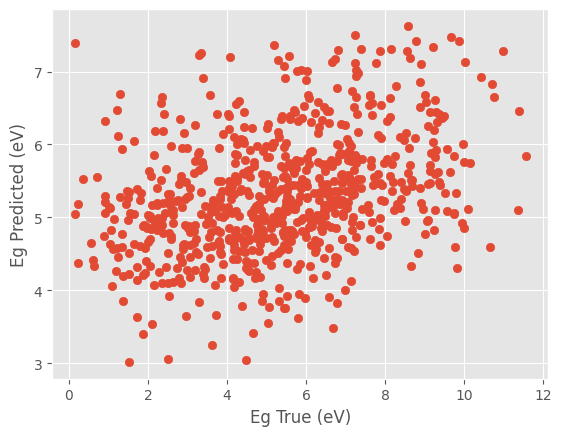

In [12]:
# fit linear regression model
model = LinearRegression().fit(X, y)


# make predictions
y_pred = model.predict(X)


# compute some fitting error
print('MSE = %f eV' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f eV' % metrics.mean_absolute_error(y, y_pred))


# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred) # complete this line
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

<details>
<summary>Solution:</summary>
    
```python
model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

print('MSE = %f' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f' % metrics.mean_absolute_error(y, y_pred))

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()
```
    
</details>

## Exercise

By changeing the features in the $X$ values above try a number of different feature combinations. How does it affect the quality of fitting? Report the feature and the MAE and MSE scores in the table below. *Note* to edit the contets of this cell, simply double click on the cell.

| Feature | MAE (eV) | MSE (eV) |
|---------|----------|----------|
|         |          |          |
|         |          |          |
|         |          |          |
|         |          |          |

---

# Gradient Boosting Regression

Gradient boosting is a method for building an ensemble of weak learners to constitute a single strong learner. We build a series of decision trees, each subsequent tree taking in information about the residuals (errors) from the previous trees. In principle, the fitting should improve each time a new tree is added.

## 1. Create the regressor

In `sklearn`, a gradient boosting regressor is created by

```python
GradientBoostingRegressor(loss=<str>, max_depth=<int>, learning_rate=<float>,
                          min_samples_split=<int>, min_samples_leaf=<int>,
                          max_features=<int>, subsample=<float>, n_estimators=<int>)
```


The hyperparameters we need to set include:

* `loss`: a loss function to be minimised. We will use 'absolute_error'.
* `max_depth`: the maximum depth limits the number of nodes in the trees; its best value depends on the interaction of the input variables; we will start with 10 and can tune it later.
* `learning_rate`: learning rate shrinks the contribution of each tree; there is a trade-off between learning rate and boosting steps; we will start with 0.015 and can tune it later.
* `min_samples_split`: the minimum number of samples required to split an internal node; we will start with 50 and can tune it later.
* `min_samples_leaf`: the minimum number of samples required to be at a leaf node; we set this as 1.
* `max_features`: the number of features to consider when looking for the best split; we will use the number of features in the data.
* `subsample`: the fraction of samples to be used for fitting the individual trees; if smaller than 1.0, this results in Stochastic Gradient Boosting. we will start with 0.9 and can tune it later.
* `n_estimators`: the number of boosting steps or decision trees; we will start with 150 and can tune it later.

**NOTE**: Simply adding more trees can lead to overfitting. Gradient boosting is quite robust against overfitting, but we will have to look out for this.

In [13]:
# create the regressor
gbr = GradientBoostingRegressor(loss='absolute_error', max_depth=10, learning_rate=0.015,
                                min_samples_split=50, min_samples_leaf=1,
                                max_features=len(oxides.columns)-1, subsample=0.9,
                                n_estimators=150)

## 2. Fit the regressor

Here we combine all the descriptors to form $x$ and fit the model:

In [14]:
# combine all the columns into X
cols = [a for a in list(oxides.columns) if a not in ['gllbsc_gap']]
X = oxides[cols].values
print('Shape of X: %s' % str(X.shape))

Shape of X: (749, 148)


In [15]:
# fit the GradientBoostingRegressor model
gbr.fit(X, y)

GradientBoostingRegressor(learning_rate=0.015, loss='absolute_error',
                          max_depth=10, max_features=148, min_samples_split=50,
                          n_estimators=150, subsample=0.9)

<details>
<summary>Solution:</summary>
    
```python
gbr.fit(X, y)
```
    
</details>

After fitting the model, we can make predictions and plot them against the original data. The fit has shown a significant improvement over linear regression.

MSE = 0.788123 eV
MAE = 0.592427 eV


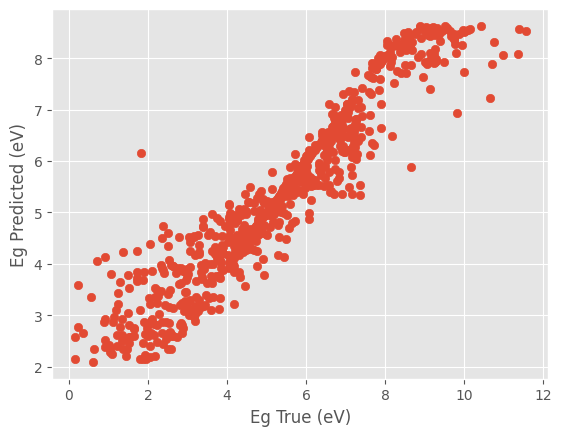

In [16]:
# make predictions
y_pred = gbr.predict(X)

# compute some fitting error
print('MSE = %f eV' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f eV' % metrics.mean_absolute_error(y, y_pred))

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()


<details>
<summary>Solution:</summary>
    
```python
y_pred = gbr.predict(X)
    
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.show()
```
    
</details>

## 3. Cross validation

<details>
<summary>More details:</summary>

Cross-validation (CV) allows us to evaluate the out-of-sample goodness-of-fit of the regressor without sparing a validation set. In the basic approach, as called the k-fold CV, the training set is split into $k$ subsets, each serving as the validation set to evaluate the model trained with the other $k-1$ subsets. This approach can be computationally expensive but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage for problems with limited data. Note that a lower CV score means better goodness of fit.
    
</details>


In the following cell, we compute the scores using 5 folds (so 20% of data for each validation) and the negative MAE as the metric:

In [17]:
# compute cross validation score
scores = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))

Cross validation score: 1.001149320977215


## 4. Boosting rate and overfitting

Let us split the dataset 80:20 into training and test sets. Re-fit the model using the training set only. We can then use some built-in methods of `GradientBoostingRegressor` to get training and test scores at each iteration of boosting. This way, we can check if we have insufficient boosting layers or perhaps we have too many and thus suffer overfitting.


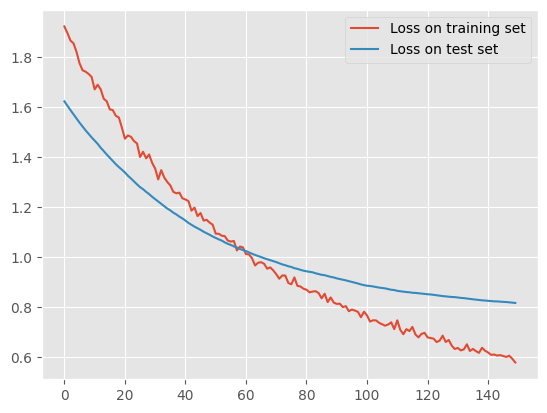

In [18]:
# split 20 % of the data from testing and the rest for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# fit the GradientBoostingRegressor model to the training set
gbr.fit(X_train, y_train)


# compute test score at each boosting step
test_score = np.zeros((150,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr._loss(y_test, y_pred)

# plot the scores
plt.figure(dpi=100)
plt.plot(gbr.train_score_, label='Loss on training set')
plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

<details>
<summary>Solution:</summary>

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
gbr.fit(X_train, y_train)
```
    
</details>

In [19]:
# calculate the final loss for the trained GradientBoostingRegressor
gbr._loss(y_test, y_pred)

0.81675240505915

Notice that the loss of both training and test are still decreasing at 150 steps. We can try to increase the boosting steps to 300 and see if we can still get improvements. If the test score stops increasing, we are probably in a good place to stop extending the model.

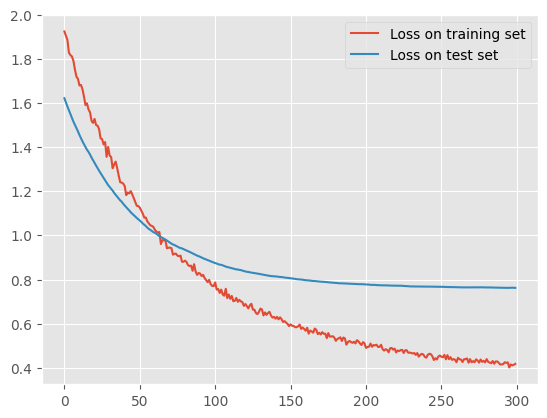

In [20]:
# create the regressor with more boosting steps
gbr300 = GradientBoostingRegressor(loss='absolute_error', max_depth=10, learning_rate=0.015,
                                   min_samples_split=50, min_samples_leaf=1,
                                   max_features=len(oxides.columns)-1, subsample=0.9,
                                   n_estimators=300)

# fit with training set
gbr300.fit(X_train, y_train)


# compute test score at each boosting step
test_score = np.zeros((300,), dtype=np.float64)
for i, y_pred in enumerate(gbr300.staged_predict(X_test)):
    test_score[i] = gbr300._loss(y_test, y_pred)

# plot the scores
plt.figure(dpi=100)
plt.plot(gbr300.train_score_, label='Loss on training set')
plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

<details>
<summary>Solution:</summary>

```python
gbr300 = GradientBoostingRegressor(loss='absolute_error', max_depth=10, learning_rate=0.015,
                                   min_samples_split=50, min_samples_leaf=1,
                                   max_features=len(oxides.columns)-1, subsample=0.9,
                                   n_estimators=300)
    
gbr300.fit(X_train, y_train)
```
    
</details>

Again, do a 5-fold cross validation at this point. How does the score compare to the earlier one?

In [21]:
# compute cross validation score
scores = cross_val_score(gbr300, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))

Cross validation score: 0.9289453155335657


##  5. Systematic hyperparameter tuning

Hand tuning a large number of hyperparameters is laborious. Luckily, `sklearn` provides a function [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to automate searches in the hyperparameter space. Even though, performing a grid-search of all of the hyperparameters at once would again lead to a combinatorial explosion. A general strategy for tuning hyperparameters in gradient boosted trees has been suggested [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems.
2. Determine the optimum number of trees for this learning rate. This should range around 40 to 90. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees.
4. Lower the learning rate and increase the estimators proportionally to get more robust models.

We will follow the above process to tune our regressor.

### Step 1 & 2: Optimise `n_estimators` with `learning_rate=0.1`

In [22]:
# candidates
param_test_n_est = {'n_estimators': range(40, 90, 10)}

# create the regressor
gbr_n_est = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1,
                                      max_features=len(cols), max_depth=10,
                                      min_samples_split=50, subsample=0.9,
                                      random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_n_est, param_grid = param_test_n_est,
                       scoring='neg_median_absolute_error', cv=5)

# perform search
gsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 max_depth=10, max_features=148,
                                                 min_samples_split=50,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'n_estimators': range(40, 90, 10)},
             scoring='neg_median_absolute_error')

In [23]:
# print best n_estimators
gsearch.best_params_

{'n_estimators': 80}

### Step 3: Optimise tree parameters with best `n_estimators`

Here we consider `max_depth` and `min_samples_split`:

In [24]:
# candidates
param_test_tree = {'max_depth': range(5, 16, 2),
                   'min_samples_split': range(10, 100, 20)}

# create the regressor
gbr_tree = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1,
                                     max_features=len(cols), n_estimators=80,
                                     subsample=0.9, random_state=0)


# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_tree, param_grid = param_test_tree,
                       scoring='neg_median_absolute_error', cv=5)


# perform search
gsearch.fit(X, y)


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 max_features=148,
                                                 n_estimators=80,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 100, 20)},
             scoring='neg_median_absolute_error')

<details>
<summary>Solution:</summary>
    
```python
gbr_tree = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1,
                                     max_features=len(cols), subsample=0.9,
                                     n_estimators=70, random_state=0)
    
gsearch = GridSearchCV(estimator= gbr_tree, param_grid = param_test_tree,
                       scoring='neg_median_absolute_error', cv=5)
    
gsearch.fit(X, y)
```
    
</details>

In [25]:
# print best max_depth and min_samples_split
gsearch.best_params_


{'max_depth': 15, 'min_samples_split': 30}

<details>
<summary>Solution:</summary>
    
```python
gsearch.best_params_
```
    
</details>

### Step 4: Lower `learning_rate` and increase `n_estimators`

Here we use a factor of 5, so `learning_rate` is lowered to 0.02 and `n_estimators` increased to 350:

In [26]:
# create the "optimised" regressor
gbr_opt = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.02,
                                    max_features=len(cols), max_depth=7,
                                    min_samples_split=10, subsample=0.9,
                                    n_estimators=350, random_state=0)


# fit the model
gbr_opt.fit(X, y)


GradientBoostingRegressor(learning_rate=0.02, loss='absolute_error',
                          max_depth=7, max_features=148, min_samples_split=10,
                          n_estimators=350, random_state=0, subsample=0.9)

<details>
<summary>Solution:</summary>

```python
gbr_opt = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.02,
                                    max_features=len(cols), max_depth=7,
                                    min_samples_split=10, subsample=0.9,
                                    n_estimators=350, random_state=0)


gbr_opt.fit(X, y)
```

</details>

Eventually, we can use our "optimised" model to make predictions and compute CV scores:

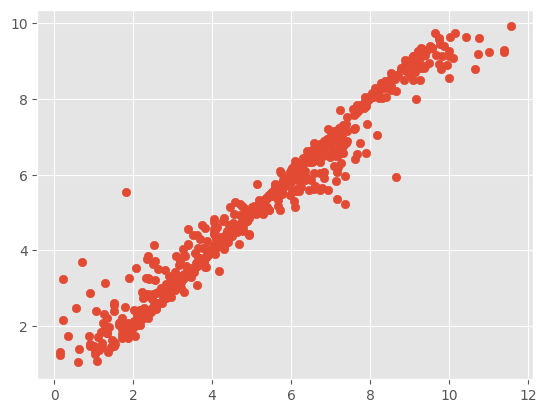

Cross validation score: 0.9060351163565559


In [27]:
# make predictions
y_pred = gbr_opt.predict(X)


# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.show()


# compute cross validation score
scores = cross_val_score(gbr_opt, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))


<details>
<summary>Solution:</summary>
    
```python
# make predictions
y_pred = gbr_opt.predict(X)

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.show()

# compute cross validation score
scores = cross_val_score(gbr_opt, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))
```
    
</details>

**Yes, our efforts pay off**, as shown by the figure and the CV score!

---

## Exercises

Similar to [classification_decision_tree.ipynb](classification_decision_tree.ipynb), use regression trees to fit one or some of the standard "toy" datasets embedded in `sklearn`, such as `boston-house-prices` and `diabetes`. These datasets are less challenging than our example.

In [28]:
# load california dataset
california = sklearn.datasets.fetch_california_housing()
print(california['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce